## Task VIII: Vision transformer/Quantum Vision Transformer

#### Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail

## SETUP

In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import math
from sklearn.metrics import recall_score, precision_score, f1_score

In [126]:
#For reproducible results and deterministic behaviour
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

## Loading the data


In [127]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [128]:
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [129]:
BATCH_SIZE=64
train_loader=torch.utils.data.DataLoader(training_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)

In [130]:
img,label=next(iter(train_loader))


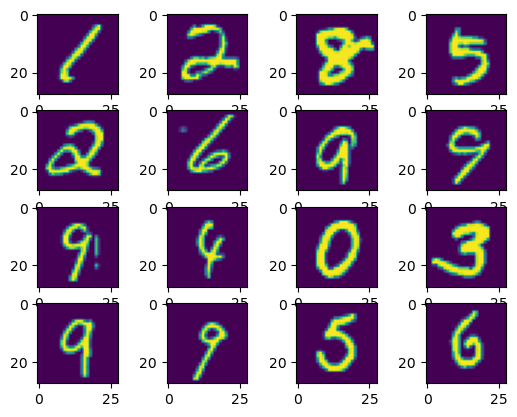

In [131]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(img[i].reshape(28,28,1))

Implementation of vision transformer has been done in such a manner that later on changing few lines of code we can get Quantum Vision Transformer.

Following [paper] and their official [code] implementation were referred in order the make the code such scalable.

This is the [official paper] of Vision Transformers

[official paper]: https://arxiv.org/pdf/2010.11929v2.pdf

[paper]: https://arxiv.org/pdf/2110.06510.pdf

[code]: https://github.com/rdisipio/qtransformer

In [132]:
class Patch_Embed(nn.Module):
    def __init__(self,img_size,patch_size,in_channels=1,embed_dim=784):
        super().__init__()
        self.img_size=img_size
        self.patch_size=patch_size
        self.n_patches= (img_size//patch_size) ** 2
        self.proj= nn.Conv2d(in_channels,embed_dim,
                             kernel_size=patch_size,stride=patch_size)
    def forward(self,x):
        x=self.proj(x)
        x=x.flatten(2)
        x=x.transpose(1,2)
        
        return x

In [133]:
class MultiHeadAttentionBase(nn.Module):
    def __init__(self,
                 embed_dim,
                 num_heads,
                 dropout = 0.1):
        super(MultiHeadAttentionBase, self).__init__()

        assert embed_dim % num_heads == 0, f"Embedding dimension ({embed_dim}) should be divisible by number of heads ({num_heads})"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads  # projection dimensions
        self.k_linear = None
        self.q_linear = None
        self.v_linear = None
        self.combine_heads = None
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None
    
    def separate_heads(self, x):
        '''
        split into N heads
        from (batch_size, seq_len, embed_dim)
        to   (batch_size, seq_len, num_heads, embed_dim)
        then transpose (1,2) to (batch_size, num_heads, seq_len, embed_dim)
        to make mat mult straightforward for each head
        '''
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)

    def attention(self, query, key, value,dropout=None):
        '''
        Attention(Q, K, V) = softmax(Q K^T / sqrt(d_k))V
        '''
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        # see also: https://tensorchiefs.github.io/dlday2018/tutorial/einsum.html
        #scores = torch.einsum('bijh, bkjh -> bikh', query, key) / math.sqrt(self.d_k)
        scores = F.softmax(scores, dim=-1)
        if dropout is not None:
            scores = dropout(scores)
        attn = torch.matmul(scores, value)
        return attn, scores
    
    def downstream(self, query, key, value, batch_size):
        Q = self.separate_heads(query)
        K = self.separate_heads(key)
        V = self.separate_heads(value)

        x, self.attn_weights = self.attention(Q, K, V, dropout=self.dropout)

        concat = x.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        return concat
        # output = self.combine_heads(concat)
        # return output

    def forward(self, x):
        raise NotImplementedError("Base class does not execute forward function.")
        
class MultiHeadAttentionClassical(MultiHeadAttentionBase):
    def __init__(self, embed_dim,
                 num_heads,
                 dropout=0.1):
        super(MultiHeadAttentionClassical, self).__init__(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)

        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.combine_heads = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x):
        n_samples,n_tokens , embed_dim = x.size()
        assert embed_dim == self.embed_dim, f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        K = self.k_linear(x)
        Q = self.q_linear(x)
        V = self.v_linear(x)

        x = self.downstream(Q, K, V, n_samples)
        output = self.combine_heads(x)
        return output
        

In [134]:
class FeedForwardBase(nn.Module):
    def __init__(self, embed_dim, ffn_dim, dropout=0.1):
        super(FeedForwardBase, self).__init__()
        self.linear_1 = nn.Linear(embed_dim, ffn_dim)
        self.linear_2 = nn.Linear(ffn_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        raise NotImplementedError("Base class does not implement forward function")


class FeedForwardClassical(FeedForwardBase):
    def __init__(self, embed_dim, ffn_dim, dropout=0.1):
        super(FeedForwardClassical, self).__init__(embed_dim, ffn_dim, dropout)

    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [62]:
class TransformerBlock(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 ffn_dim: int,
                 dropout: float = 0.1):
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadAttentionClassical(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.ffn = FeedForwardClassical(embed_dim, ffn_dim) 
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output = self.attn(x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

In [44]:
class TransformerBlockBase(nn.Module):
    def __init__(self,
                 embed_dim,
                 num_heads,
                 ffn_dim,
                 dropout = 0.1):
        super(TransformerBlockBase, self).__init__()
        self.attn = MultiHeadAttentionClassical(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.ffn = FeedForwardClassical(embed_dim=embed_dim, ffn_dim=ffn_dim,dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim,eps=1e-6)
        self.norm2 = nn.LayerNorm(embed_dim,eps=1e-6)

    def forward(self, x):
        attn_output = self.attn(x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)
        

        return x





In [135]:
class Vision_Transformer(nn.Module):
    def __init__(self,img_size,patch_size,in_channels,ffn_dim,
                 embed_dim=768,depth=4,num_heads=12,dropout=0.1):
        
        super().__init__()

        self.patch_embed=Patch_Embed(img_size,patch_size,in_channels,embed_dim)
        self.cls_token=nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed=nn.Parameter(torch.zeros(1,1+self.patch_embed.n_patches,embed_dim))
        self.pos_drop=nn.Dropout(dropout)
        
        self.blocks=nn.ModuleList([TransformerBlock(embed_dim=embed_dim,num_heads=num_heads,
                                                        ffn_dim=ffn_dim,dropout=dropout) for _ in range(depth)])
        
        self.norm= nn.LayerNorm(embed_dim,eps=1e-6)
        self.head=nn.Linear(embed_dim,10)
        
    def forward(self,x):
        n_samples=x.shape[0]
        x=self.patch_embed(x)
        
        cls_token=self.cls_token.expand(n_samples,-1,-1)
        x=torch.cat((cls_token,x),dim=1)
        x=x+self.pos_embed
        x=self.pos_drop(x)
        
        for block in self.blocks:
            x= block(x)
            
        x=self.norm(x)
        
        cls_token_final=x[:,0]
        
        x=self.head(cls_token_final)
        
        return x
        


In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=Vision_Transformer(img_size=28,patch_size=7,in_channels=1,ffn_dim=64,depth=2).to(device)
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
        model.parameters(), lr=3e-4)

In [137]:
print(model)

Vision_Transformer(
  (patch_embed): Patch_Embed(
    (proj): Conv2d(1, 768, kernel_size=(7, 7), stride=(7, 7))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): TransformerBlock(
      (attn): MultiHeadAttentionClassical(
        (dropout): Dropout(p=0.1, inplace=False)
        (k_linear): Linear(in_features=768, out_features=768, bias=True)
        (q_linear): Linear(in_features=768, out_features=768, bias=True)
        (v_linear): Linear(in_features=768, out_features=768, bias=True)
        (combine_heads): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): FeedForwardClassical(
        (linear_1): Linear(in_features=768, out_features=64, bias=True)
        (linear_2): Linear(in_features=64, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affi

In [138]:
N_EPOCHS=10
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
train_loss_history=[]
train_accuracy_history=[]
criterion = nn.CrossEntropyLoss()
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    correct=0
    total=0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.detach().cpu().item() / len(train_loader)
        predictions = torch.max(outputs, 1)[1].to(device)
        #print(predictions.shape)
        #print(labels.shape)
        #predictions_list.append(predictions)
        correct += (predictions == labels).sum()
            
        total += len(labels)
            

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = 100 * correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(accuracy)
    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f} accuracy:{accuracy}")

Epoch 1 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10 loss: 0.53 accuracy:82.98333740234375


Epoch 2 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10 loss: 0.20 accuracy:93.70166778564453


Epoch 3 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10 loss: 0.16 accuracy:95.17166900634766


Epoch 4 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10 loss: 0.14 accuracy:95.69833374023438


Epoch 5 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10 loss: 0.12 accuracy:96.07666778564453


Epoch 6 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10 loss: 0.12 accuracy:96.35166931152344


Epoch 7 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10 loss: 0.11 accuracy:96.42333221435547


Epoch 8 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10 loss: 0.12 accuracy:96.11499786376953


Epoch 9 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10 loss: 0.11 accuracy:96.59333801269531


Epoch 10 in training:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10 loss: 0.09 accuracy:96.97833251953125


Text(0, 0.5, 'accuracy')

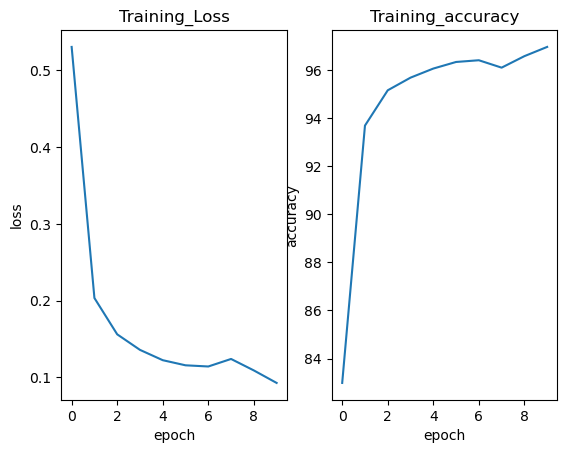

In [139]:
plt.subplot(1,2,1)
plt.plot(range(N_EPOCHS),train_loss_history)
plt.title('Training_Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(range(N_EPOCHS),[x.detach().cpu() for x in train_accuracy_history])
plt.title('Training_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

## Displaying precision,recall and f1_score for each and every class for test data.



In [140]:
targets=[]
test_predictions=[]
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader):
        imgs,labels = batch
        imgs,labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        #print(labels.shape)
        #print(output.shape)
        loss = criterion(output, labels)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        predictions = torch.max(output, 1)[1].to(device)
        #print(predictions.shape)
        test_predictions.append(predictions.cpu())
        correct += (predictions == labels).sum()
        targets.append(labels.cpu())
            
        total += len(labels)
test_predictions=torch.concat(test_predictions)
targets=torch.concat(targets)
precision = precision_score(targets,test_predictions,average=None)
recall = recall_score(targets, test_predictions,average=None)
f1 = f1_score(targets,test_predictions,average=None)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {correct / total * 100:.2f}%")

  0%|          | 0/157 [00:00<?, ?it/s]

Precision: [0.97433265 0.98592788 0.97642436 0.9507722  0.9486166  0.98677885
 0.97077244 0.95893028 0.97305699 0.94809011]
Recall: [0.96836735 0.9876652  0.96317829 0.97524752 0.97759674 0.92040359
 0.97077244 0.9766537  0.96406571 0.95936571]
F1: [0.97134084 0.98679577 0.9697561  0.96285435 0.96288867 0.95243619
 0.97077244 0.96771084 0.96854048 0.95369458]
Test loss: 0.11
Test accuracy: 96.71%


## Displaying precision,recall and f1_score globally for all classes by calculating total true positives, false negatives and false positives for test data.


In [141]:
targets=[]
test_predictions=[]
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader):
        imgs,labels = batch
        imgs,labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        #print(labels.shape)
        #print(output.shape)
        loss = criterion(output, labels)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        predictions = torch.max(output, 1)[1].to(device)
        #print(predictions.shape)
        test_predictions.append(predictions.cpu())
        correct += (predictions == labels).sum()
        targets.append(labels.cpu())
            
        total += len(labels)
test_predictions=torch.concat(test_predictions)
targets=torch.concat(targets)
precision = precision_score(targets,test_predictions,average='micro')
recall = recall_score(targets, test_predictions,average='micro')
f1 = f1_score(targets,test_predictions,average='micro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {correct / total * 100:.2f}%")

  0%|          | 0/157 [00:00<?, ?it/s]

Precision: 0.9653
Recall: 0.9653
F1: 0.9653
Test loss: 0.11
Test accuracy: 96.53%
